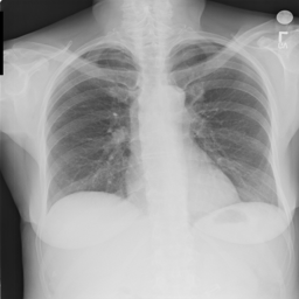

In [1]:
import numpy as np
import tensorflow as tf
import keras

import os
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from funcs_Task3 import concat_generators

img_size = (128, 128)

# The local path to our target image
img_path = "covid xray/test/COVID/COVID-2032.png"
img_path = "covid xray/test/NORMAL/NORMAL-2030.png"
display(Image(img_path))

In [2]:
np.random.seed(123)  
tf.random.set_seed(123) 

In [3]:
loaded_model = tf.keras.models.load_model('covid_xray_model.h5')  # Load the model
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,725,507 (14.21 MB)

 Trainable params: 3,725,377 (14.21 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2 (12.00 B)

### Redefine model so I have different output layer -> shape (1,1000)

- We have to change the last layer to not have a scalar as output
- I here redefined the model completely because in task 2 I made it with sequential() and then it doesn't work for some reason

In [4]:
METRICS = ["accuracy"]
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'
epochs = 30

training_data_gen = training_data_Pipeline(128, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(128, img_size, train_dir, val_dir)
full_data_gen = concat_generators(training_data_gen, val_data_gen)

total_train = val_data_gen.samples+training_data_gen.samples

learning_rate = 0.001
dropout_rate = 0.3
filters = 32
optimizer = 'sgd'

inputs = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', name="last_conv")(x)  # <-- Name this layer for Grad-CAM
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1000)(x)  # from_logits=True will handle this

redefined_model = Model(inputs, outputs)

redefined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

redefined_model.summary()

history = redefined_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs
)

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │        65,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,918,536 (7.32 MB)

 Trainable params: 1,918,472 (7.32 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4668 - loss: 2.6878
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7290 - loss: 0.6629
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7719 - loss: 0.4785
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8007 - loss: 0.4294
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8010 - loss: 0.4361
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 950ms/step - accuracy: 0.8274 - loss: 0.3840
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8347 - loss: 0.3675
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8457 - loss: 0.3552
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8301 - loss: 0.3591
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8556 - loss: 0.3402
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8652 - loss: 0.3006
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8597 -

### Functions to get image array and to make Grad-CAM map (from tutorial)

In [5]:
def get_img_array(img_path, size):

    img = keras.utils.load_img(img_path, target_size=size)

    array = keras.utils.img_to_array(img)

    # We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, sublayer = None, pred_index=None):
    
    if sublayer is None:
        output = model.get_layer(last_conv_layer_name).output
    else:
        output = model.get_layer(last_conv_layer_name).get_layer(sublayer).output

    # First, we create a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        
        model.inputs, [output, model.output]
    )

    # We compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        # For binary classification, just get the scalar output ????
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Average the gradients along the spatial dimension to get a proxy for the channel importance
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    #averaging the activations along the channel dimension, weighting each channel according to its importance
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

### grad-CAM for redefined baseline model

Image shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
(1, 1000)
[-1.594303]


c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_45']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


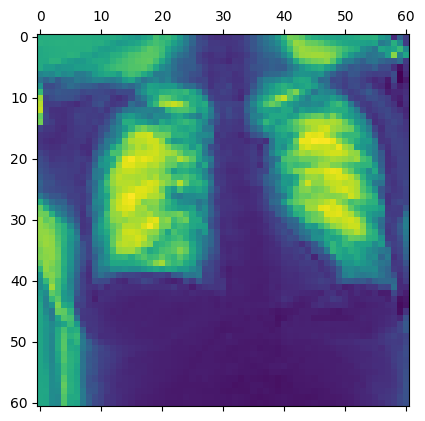

In [6]:

preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print("Image shape:", img_array.shape)

redefined_model.layers[-1].activation = None

# Print what the top predicted class is
preds = redefined_model.predict(img_array)
print(preds.shape)
print(preds[:,3])
heatmap = make_gradcam_heatmap(img_array, redefined_model, "last_conv")

# Display heatmap
plt.matshow(heatmap)
plt.show()


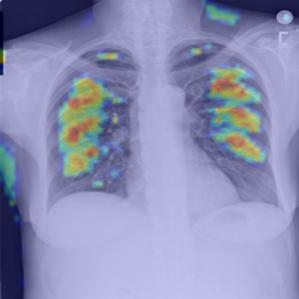

In [7]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, threshold=0.8):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.maximum(heatmap, threshold)
    heatmap = (heatmap - threshold) / (heatmap.max() - threshold + 1e-8)  # Normalize after thresholding

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

### Now lets try for Resnet model of task 3

In [8]:
loaded_model = load_model("ResNet_model.h5")
loaded_model.summary()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Get all layers except the last one
x = loaded_model.layers[-2].output  # or however many layers back you want to go
outputs = Dense(1000)(x)

# Create a new model with modified output
new_model = Model(inputs=loaded_model.input, outputs=outputs)

# Compile with new loss (e.g., categorical crossentropy if 1000-class classification)
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'ResNet_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
#last sublayers inside resnet
print(new_model.get_layer("resnet50v2").layers[-1].name)
print(new_model.get_layer("resnet50v2").layers[-2].name)
print(new_model.get_layer("resnet50v2").layers[-3].name)

post_relu
post_bn
conv5_block3_out


### Model from task 3: doesn't work 
- It seem that we cannot get to the output of the convolutional layers that are inside the pretrained resnet block
- Maybe we could add another conv layer to the model so we can get that output
- Or maybe there is a way to store resnet output while making the model in task 3?

In [ ]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print("Image shape:", img_array.shape)

new_model.layers[-1].activation = None

preds = new_model.predict(img_array)
print(preds.shape)

heatmap = make_gradcam_heatmap(img_array, new_model, "resnet50v2", sublayer="conv5_block3_out")

# Display heatmap
plt.matshow(heatmap)
plt.show()

Image shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1, 1000)


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m2195541813760\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[-0.19215685, -0.19215685, -0.19215685],\n         [-0.62352943, -0.62352943, -0.62352943],\n         [-0.7882353 , -0.7882353 , -0.7882353 ],\n         ...,\n         [-0.654902  , -0.654902  , -0.654902  ],\n         [-0.654902  , -0.654902  , -0.654902  ],\n         [-0.60784316, -0.60784316, -0.60784316]],\n\n        [[-0.64705884, -0.64705884, -0.64705884],\n         [-0.92941177, -0.92941177, -0.92941177],\n         [-0.99215686, -0.99215686, -0.99215686],\n         ...,\n         [-0.96862745, -0.96862745, -0.96862745],\n         [-0.96862745, -0.96862745, -0.96862745],\n         [-0.88235295, -0.88235295, -0.88235295]],\n\n        [[-0.58431375, -0.58431375, -0.58431375],\n         [-0.8980392 , -0.8980392 , -0.8980392 ],\n         [-0.9843137 , -0.9843137 , -0.9843137 ],\n         ...,\n         [-1.        , -1.        , -1.        ],\n         [-1.        , -1.        , -1.        ],\n         [-0.8901961 , -0.8901961 , -0.8901961 ]],\n\n        ...,\n\n        [[-0.88235295, -0.88235295, -0.88235295],\n         [-0.99215686, -0.99215686, -0.99215686],\n         [-0.99215686, -0.99215686, -0.99215686],\n         ...,\n         [-0.99215686, -0.99215686, -0.99215686],\n         [-0.8352941 , -0.8352941 , -0.8352941 ],\n         [-0.38039213, -0.38039213, -0.38039213]],\n\n        [[-0.85882354, -0.85882354, -0.85882354],\n         [-0.92156863, -0.92156863, -0.92156863],\n         [-0.92156863, -0.92156863, -0.92156863],\n         ...,\n         [-0.9843137 , -0.9843137 , -0.9843137 ],\n         [-0.81960785, -0.81960785, -0.81960785],\n         [-0.3960784 , -0.3960784 , -0.3960784 ]],\n\n        [[-0.7411765 , -0.7411765 , -0.7411765 ],\n         [-0.79607844, -0.79607844, -0.79607844],\n         [-0.79607844, -0.79607844, -0.79607844],\n         ...,\n         [-0.92156863, -0.92156863, -0.92156863],\n         [-0.7647059 , -0.7647059 , -0.7647059 ],\n         [-0.3960784 , -0.3960784 , -0.3960784 ]]]], dtype=float32)\n  • training=None\n  • mask=None'

# Explaining the decision with Grad-CAM

In [27]:
def get_gradcam_image(img_path, heatmap, alpha=0.4, threshold=0.8):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.maximum(heatmap, threshold)
    heatmap = (heatmap - threshold) / (heatmap.max() - threshold + 1e-8)  # Normalize after thresholding

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return(superimposed_img)


In [26]:
## divide test data into groups
# gather necessary data
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle = False)
y_pred_probs = loaded_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_data_gen.classes

filepaths = test_data_gen.filepaths
class_indices = test_data_gen.class_indices

# save filepaths of images in 4 classes, based on right or wrong classification and true value
y_pred_covid = (y_pred == class_indices["COVID"])
y_true_covid = (y_true == class_indices["COVID"])

Covid_misclassified = [filepaths[i] for i in range(len(filepaths)) if y_true_covid[i] & ~y_pred_covid[i]]
Covid_correctclassified = [filepaths[i] for i in range(len(filepaths))  if y_true_covid[i] & y_pred_covid[i]]
normal_misclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & y_pred_covid[i]]
normal_correctclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & ~y_pred_covid[i]]


Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


In [ ]:
# sanity check classes
len(Covid_misclassified)+len(Covid_correctclassified)+len(normal_correctclassified)+len(normal_misclassified)

200

In [35]:
# function plotting some images with grad-cam
def show_some_gradcams_from_list(list, img_size, model, start_index = 0, stop_index = 5 ):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(list[start_index:stop_index]):
        # make gradcam image
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        heatmap = make_gradcam_heatmap(img_array, model, "last_conv")
        img = get_gradcam_image(img_path, heatmap)

        # plot gradcam image
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

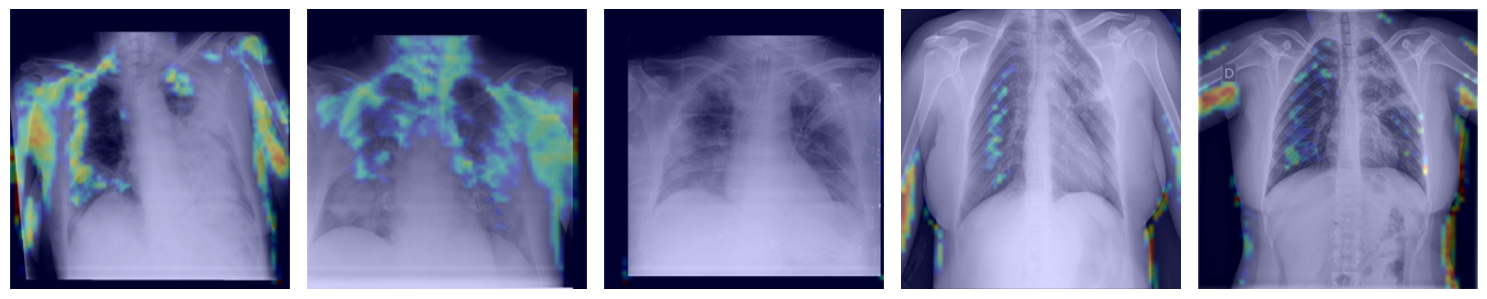

In [ ]:
#Covid cases that are misclassified by the model as normal
show_some_gradcams_from_list(Covid_misclassified, img_size, redefined_model, start_index = 20, stop_index = 25 )

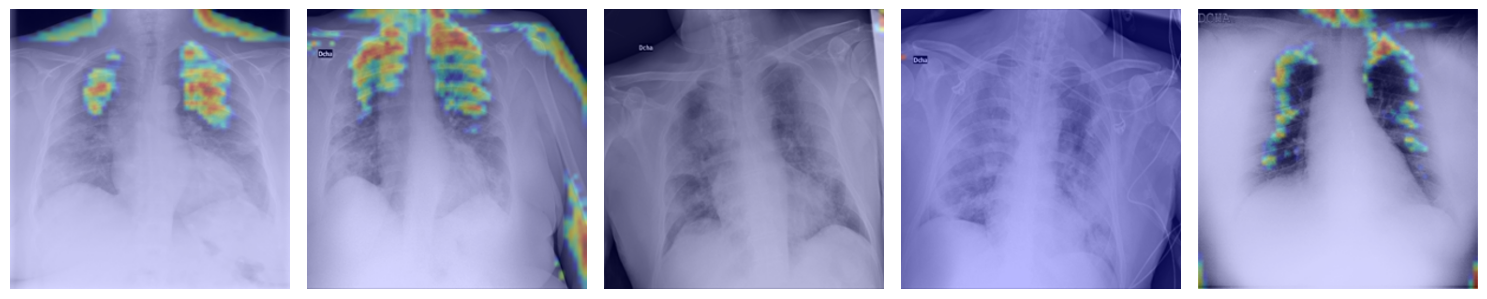

In [54]:
#Covid cases that are correctly classified by the model 
show_some_gradcams_from_list(Covid_correctclassified, img_size, redefined_model, start_index = 20, stop_index = 25 )

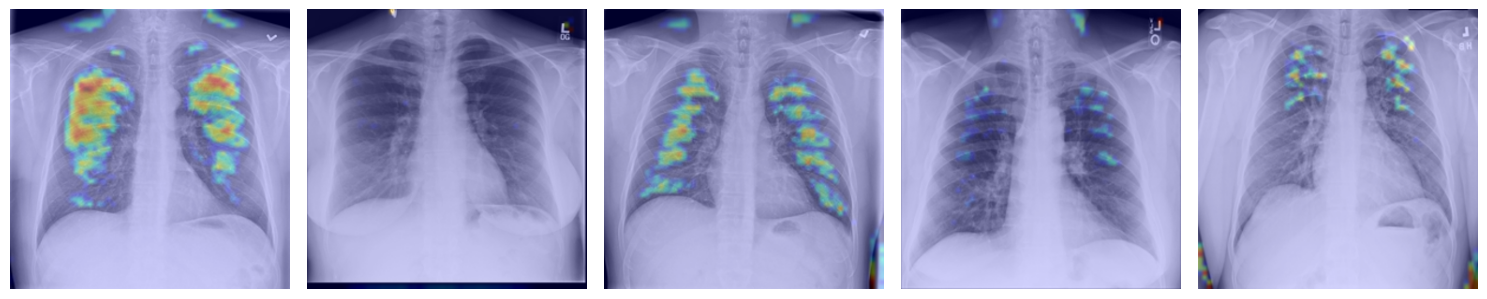

In [58]:
#normal cases that are incorrectly classified by the model as covid cases
show_some_gradcams_from_list(normal_misclassified, img_size, redefined_model, start_index = 5, stop_index = 10 )

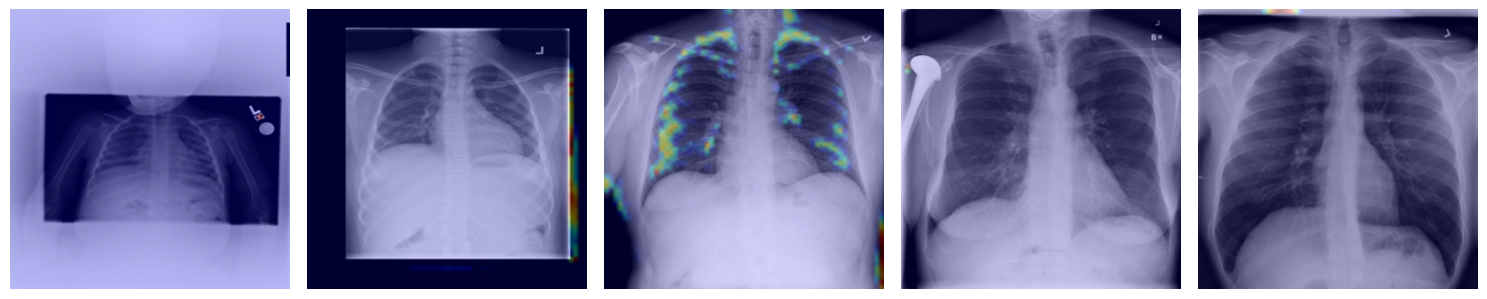

In [61]:
#normal cases that are correctly classified by the model
show_some_gradcams_from_list(normal_correctclassified, img_size, redefined_model, start_index = 0, stop_index = 5 )